### Querying the data

The data provided came from the sources listed below:
  1.Box Office Mojo
  2.IMDB
  3.Rotten Tomatoes
  4.TheMovieDB
  5.The Numbers
  
Our first task is to import and inspect the data. We start off with IMDB, which is in SQL format

In [457]:
# import the required modules
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [458]:
# open up a connection
conn = sqlite3.connect('im.db')

# initialize a cursor
cur = conn.cursor()

### Table Names

Below we inspect the database to get an overview of the tables contained

In [459]:
table_name_query = """SELECT name 
                      AS 'Table Names' 
                      FROM sqlite_master 
                      WHERE type='table';"""

pd.read_sql(table_name_query, conn)

,Table Names
0,movie_basics
1,directors
2,known_for
3,movie_akas
4,movie_ratings
5,persons
6,principals
7,writers


### Movie Ratings Table
We'll start with exploring the movie_ratings table. The table has no missing values, and the movie_id column has no duplicates.

In [460]:
ratings = """SELECT * 
                      FROM movie_ratings;"""

df_ratings = pd.read_sql(ratings, conn)

# check columns with missing data
print("columns with missing values")
print(df_ratings.isnull().any())
print('\n')

# check columns with duplicated data
print("columns with duplicates")
for output in [df_ratings[col].duplicated().value_counts() for col in df_ratings.columns]:
    print('\n')
    print(output)

print('\n')
print(f'df_ratings has {df_ratings.shape[0]} rows & {df_ratings.shape[1]} columns')

df_ratings.head()

columns with missing values
movie_id         False
averagerating    False
numvotes         False
dtype: bool


columns with duplicates


False    73856
Name: movie_id, dtype: int64


True     73765
False       91
Name: averagerating, dtype: int64


True     66507
False     7349
Name: numvotes, dtype: int64


df_ratings has 73856 rows & 3 columns


,movie_id,averagerating,numvotes
0,tt10356526,8.3,31
1,tt10384606,8.9,559
2,tt1042974,6.4,20
3,tt1043726,4.2,50352
4,tt1060240,6.5,21


In [461]:
df_ratings.describe()

,averagerating,numvotes
count,73856.000000,7.385600e+04
mean,6.332729,3.523662e+03
std,1.474978,3.029402e+04
min,1.000000,5.000000e+00
25%,5.500000,1.400000e+01
50%,6.500000,4.900000e+01
75%,7.400000,2.820000e+02
max,10.000000,1.841066e+06


### Check for Outliers
A simple look at the boxplot of movie rating and number of votes shows that we have some outliers. However, a scatterplot of the relationship between these 2 variables show that there is a very weak linear relationship between number of votes cast and the movie rating received. I therefore argue that these outliers are naturally occurring and should therefore not be removed

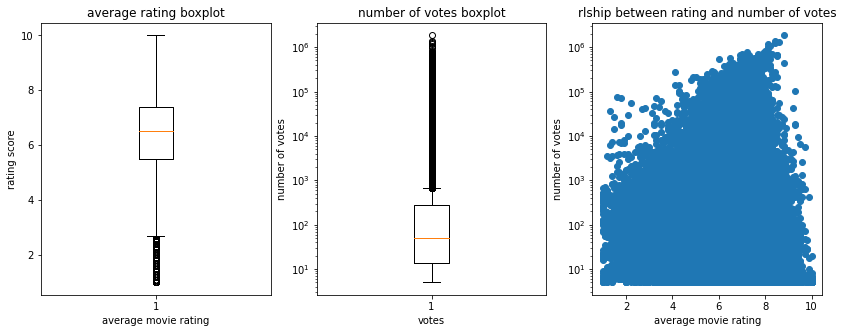

In [462]:
fig, axes = plt.subplots(figsize=(14, 5), ncols=3)

# boxplot to check average rating
axes[0].boxplot(df_ratings.averagerating)
axes[0].set_title('average rating boxplot')
axes[0].set_xlabel('average movie rating')
axes[0].set_ylabel('rating score')

# boxplot to check number of votes
axes[1].boxplot(df_ratings.numvotes)
axes[1].set_title('number of votes boxplot')
axes[1].set_xlabel('votes')
axes[1].set_ylabel('number of votes')
axes[1].set_yscale('log')

# scatterplot to check relationship between rating &
# number of votes
axes[2].scatter(df_ratings.averagerating,df_ratings.numvotes)
axes[2].set_title('rlship between rating and number of votes')
axes[2].set_xlabel('average movie rating')
axes[2].set_ylabel('number of votes')
axes[2].set_yscale('log');


### Join Movie Ratings Table to Movie Basics table
Movie basics is one of the crucial tables since it shows since it shows the properties of each movie like title, year, runtime and genre. It has 146144 rows and 6 columns.

To work efficiently, I will innerjoin these two tables to shed off any movies that don't have ratings. This is because movies with no ratings have no usable metrics to analyse perforamance. So that when we start to clean the movie bascis variables we will have shed off any unnecessary data

The Movie basics table has unique movie ids. Thus it is safe to join the 2 tables on this metric before we start cleaning

In [463]:
m_basics_rate = """
SELECT *
   FROM movie_basics
  JOIN movie_ratings
  USING (movie_id);
"""

dfm_basics_rate = pd.read_sql(m_basics_rate, conn)

print(dfm_basics_rate.shape)
dfm_basics_rate.head()

(73856, 8)


,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama",7.2,43
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama,6.9,4517
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama",6.1,13
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy",6.5,119


### Check Joined Table Properties
The data has some missing values in  "runtime_minutes" (10%) & "genres" (1%) columns

There are some duplicates worth exploring - primary titles (5%) & original titles (4%) columns. Since there are no entire row duplicates, and movie ids are unique, we need to ascetain whether these are different movies with the same name, different versions of the same movie or data error

In [464]:
# check for data properties
print(dfm_basics_rate.info())
print('\n')

# check for dataframe row duplicates
print('dataframe row duplicates')
print(dfm_basics_rate.duplicated().value_counts())
print('\n')

# check for col duplicates
print('row duplicates by column')
for output in [dfm_basics_rate[col].duplicated().value_counts() for col in dfm_basics_rate.columns]:
    print('\n')
    print(output)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73856 entries, 0 to 73855
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   movie_id         73856 non-null  object 
 1   primary_title    73856 non-null  object 
 2   original_title   73856 non-null  object 
 3   start_year       73856 non-null  int64  
 4   runtime_minutes  66236 non-null  float64
 5   genres           73052 non-null  object 
 6   averagerating    73856 non-null  float64
 7   numvotes         73856 non-null  int64  
dtypes: float64(2), int64(2), object(4)
memory usage: 4.5+ MB
None


dataframe row duplicates
False    73856
dtype: int64


row duplicates by column


False    73856
Name: movie_id, dtype: int64


False    69993
True      3863
Name: primary_title, dtype: int64


False    71097
True      2759
Name: original_title, dtype: int64


True     73846
False       10
Name: start_year, dtype: int64


True     73566
False      290
Name: run

### Check for Outliers

Before we dive into duplicates, we will check for outliers in start_year & runtime_minutes

start_year has no outliers with oldest movie producted in 2010, and the most recent in 2019. It should be noted that his only holds true for the filtered databse after the join, and would not have been the case for the full table on movie basics - which is beyond the scope of this analysis. 

The descriptive statistics below show a movie with a maximum runtime of 51,420 minutes. This translates to 178 days. A quick online search shows that the movie called [Logistics](shorturl.at/epq79), is truly that long!

However, I feel that we need to clean up this variable, since we also have movies that run for 1 minute only. This however is unrealistic, and most likely due to the fact that they might have saved trailers in the database, rather than the whole movie.



In [465]:
dfm_basics_rate[['start_year', 'runtime_minutes']].describe()

,start_year,runtime_minutes
count,73856.000000,66236.000000
mean,2014.276132,94.654040
std,2.614807,208.574111
min,2010.000000,3.000000
25%,2012.000000,81.000000
50%,2014.000000,91.000000
75%,2016.000000,104.000000
max,2019.000000,51420.000000


Below I further investigate movie duration through visualisation. The first plot shows the distribution movie durations for each movie, with outliers at both the upper and lower bounds of the data. 

The second plot shows that most movies flucuate within 100 minute range, and that the movie length has no bearing on its rating. Despite this, it is impractical to have movies running for less than 10 minutes. As I result, I will use the boxplot iqr method to determine a realistic movie duration that should be used in the analysis

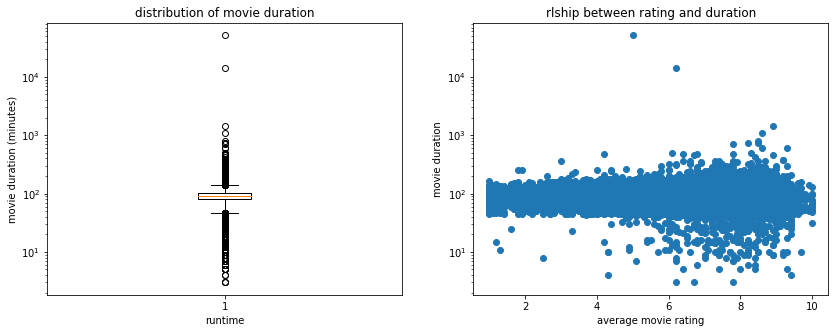

In [466]:
# visualise runtime and duration properties

fig, axes = plt.subplots(figsize=(14, 5), ncols=2)

# boxplot to check runtime
axes[0].boxplot(dfm_basics_rate.runtime_minutes.dropna())
axes[0].set_title('distribution of movie duration')
axes[0].set_xlabel('runtime')
axes[0].set_ylabel('movie duration (minutes)')
axes[0].set_yscale('log')

# scatterplot to check relationship between duration &
# rating
axes[1].scatter(dfm_basics_rate.averagerating,dfm_basics_rate.runtime_minutes)
axes[1].set_title('rlship between rating and duration')
axes[1].set_xlabel('average movie rating')
axes[1].set_ylabel('movie duration')
axes[1].set_yscale('log');


Below we use the boxplot method to identify the whiskers. Thus from below, any movie that runs for less than 46.5 minutes will be treated as a lower limit outlier.

The analysis also shows we should treat any movie above 138.5 minutes as the upper limit outlier. However, I will use 250 minutes as the upper limit outlier - given that successful movies like [Avatar 2](shorturl.at/hvwNZ) and [Avengers: Endame](shorturl.at/djlF5) clocked over 180 minutes. [Zack Snyder's Justice League](shorturl.at/nzJSU) was over 240 minutes long.

In [467]:
dfm_basics_rate[['start_year', 'runtime_minutes']].describe().runtime_minutes[6]

104.0

In [468]:
# use iqr from the boxplot to calculate outlier runtimes
q1 = dfm_basics_rate[['start_year', 'runtime_minutes']].describe().runtime_minutes[4]
q3 = dfm_basics_rate[['start_year', 'runtime_minutes']].describe().runtime_minutes[6]

iqr = q3 - q1
lower_whisk = q1 - (1.5*iqr)
upper_whisk = q3 + (1.5*iqr)
upper_count = dfm_basics_rate[dfm_basics_rate['runtime_minutes'] >= 250].shape[0]
lower_count = dfm_basics_rate[dfm_basics_rate['runtime_minutes'] <= 46.5].shape[0]

                              
print(f'lower bound: {lower_whisk}, upper bound: {upper_whisk}')
print(f'lower bound has {lower_count} which is {round(lower_count/73856, 3)}% of the data')
print(f'upper bound has {upper_count} which is {round(upper_count/73856, 3)}% of the data')

lower bound: 46.5, upper bound: 138.5
lower bound has 871 which is 0.012% of the data
upper bound has 74 which is 0.001% of the data


The code below thus removes any movie that is less than 46.5 minutes or greater than 250 minutes. Thus our sample reduces from 73,856 to 72,914.

In [469]:
# Remove outlier runtime
dfm_basics_rate = dfm_basics_rate[(dfm_basics_rate['runtime_minutes'].isnull()) | 
                              ((dfm_basics_rate['runtime_minutes'] >= 46.5) & 
                               (dfm_basics_rate['runtime_minutes'] <= 250))]

print(f'sample: {dfm_basics_rate.shape[0]} movies')
print("max_time  :", dfm_basics_rate.runtime_minutes.max())
print("min_time:", dfm_basics_rate.runtime_minutes.min())
dfm_basics_rate.head()

sample: 72914 movies
max_time  : 250.0
min_time: 47.0


,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama",7.2,43
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama,6.9,4517
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama",6.1,13
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy",6.5,119


### Investigating Duplicates in "primary_title" 
We need to make some consideration when looking at these duplicates:

1.titles may be duplicated because we have different movies with the same name. For example, in the output below, we have 2 movies with the name "100% Love". A quick Google search shows that the one produced in [2011](https://www.google.com/search?q=100+love&client=firefox-b-d&ei=85AMZJeCCofbkgXGuLTACg&gs_ssp=eJzj4tLP1TdIz7IsL0gyYPTiMDQwUMjJL0sFAEhtBk0&oq=100%25+love&gs_lcp=Cgxnd3Mtd2l6LXNlcnAQARgGMgUIABCABDIFCC4QgAQyBQgAEIAEMgUIABCABDIFCAAQgAQyBQgAEIAEMgQILhBDMgUIABCABDIFCAAQgAQyBAguEEM6CggAEEcQ1gQQsAM6BggAEBYQHjoICAAQFhAeEA86FggAEOoCELQCEIoDELcDENQDEOUCGAE6EwguEI8BEOoCELQCEIwDEOUCGAI6EwgAEI8BEOoCELQCEIwDEOUCGAI6BQgAEJECOgUILhCRAjoHCC4Q1AIQQzoRCC4QgAQQsQMQgwEQxwEQ0QM6CwgAEIAEELEDEIMBOggILhCxAxCDAToICC4Q1AIQkQI6CgguELEDENQCEEM6BwgAELEDEEM6BAgAEEM6BwguELEDEEM6CgguENQCELEDEEM6CggAELEDEIMBEEM6CAgAEIAEELEDOggIABCxAxCRAjoLCC4QgAQQsQMQgwE6CAguEIAEELEDOgUILhCxAzoICC4QsQMQkQJKBAhBGABQlRhY1NMDYIz3A2gHcAF4BIABswKIAfojkgEGMi0xOC4xmAEAoAEBsAETyAEIwAEB2gEECAEYB9oBBggCEAEYCg&sclient=gws-wiz-serp) is different from that in [2012](https://www.google.com/search?q=100+love+2012&client=firefox-b-d&ei=7xwMZMPxCpuEhbIPgKK9gAs&gs_ssp=eJzj4tLP1TfIMk5Ji08xYPTiNTQwUMjJL0tVMDIwNAIAZ18HDg&oq=100%25+love&gs_lcp=Cgxnd3Mtd2l6LXNlcnAQARgJMgUIABCABDIFCC4QgAQyBQgAEIAEMgUIABCABDIFCAAQgAQyBQgAEIAEMgUILhCABDIFCAAQgAQyBQgAEIAEMgQILhBDOhEILhCDARDHARCxAxDRAxCABDoLCAAQgAQQsQMQgwE6CAgAEIAEELEDOgsILhCABBCxAxCDAToICAAQsQMQgwE6BQguEJECOgcILhDUAhBDOggILhCABBCxAzoFCC4QsQNKBAhBGABQsxZYjjVgz6MBaABwAXgAgAGAAogB0RGSAQQyLTEwmAEAoAEBwAEB&sclient=gws-wiz-serp).
2.titles may be duplicated due to repition of the same movie name as in the case of [1989](https://www.google.com/search?client=firefox-b-d&sxsrf=AJOqlzU3nZFpP-IA_vBND1XKMbSsri616Q:1678543316627&q=1989&si=AEcPFx6vY0DhKadBB5SBEToMU9VHAhZfqDGw6RWqRSw7Z2ppKDiQdW4Vw7uSrw25sUtZ8ITFcRiymecpWMqDWxeNy_a9Gm_Spylsmbe9ucx4XEsQJcwM9jlDfkQK-mCSSSPWeKjlUiAOF9EHMPIBKtlkPOJSbZsHvq0nN-wFTSz8Vob0GXLFJQ0%3D&sa=X&ved=2ahUKEwjstYKRhdT9AhXpsKQKHdunCK4Q6RN6BAhIEAE&biw=1696&bih=829&dpr=1.13) which appears twice, with the same production year of 2014.

Due to the complexity of identifying these nuances, and given that only a small sample of 5% has more than one "primary_title" I will treat all as duplicates and drop accordingly

In [470]:
# drop the original title column
dfm_basics_rate.drop('original_title', axis=1, inplace=True)

In [471]:
dfm_basics_rate[dfm_basics_rate.primary_title.duplicated(
                keep=False)].sort_values(by='primary_title', key=lambda x: x.str.lower()).head(6)

,movie_id,primary_title,start_year,runtime_minutes,genres,averagerating,numvotes
12250,tt1859618,1,2019,100.0,Drama,9.2,13
25949,tt2518788,1,2013,112.0,"Documentary,History,Sport",8.0,3452
52873,tt5282238,10,2015,90.0,Thriller,4.7,7
13822,tt1941430,10,2011,NaN,Action,3.4,9
26727,tt2579680,100% Love,2012,166.0,"Comedy,Drama,Romance",6.0,296
12486,tt1869226,100% Love,2011,141.0,"Comedy,Drama,Romance",7.0,2331


The plots below showing the distribution of movie ratings before and after dropping duplicates show only a change in the number of ratings, while the distribution remains identical

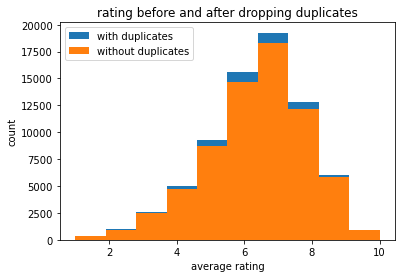

In [472]:
plt.hist(dfm_basics_rate.averagerating.values, label='with duplicates')
plt.hist(dfm_basics_rate.drop_duplicates(subset=['primary_title']).averagerating.values, label='without duplicates')
plt.title('rating before and after dropping duplicates')
plt.xlabel('average rating')
plt.ylabel('count')
plt.legend();

In [473]:
# drop duplicates on the primary title column
dfm_basics_rate.drop_duplicates(subset=['primary_title'], inplace=True)
dfm_basics_rate.shape

(69119, 7)

### Check for Missing Values
From the code below we see that movies missing runtime duration form 10% of the sample. To clean this, i will use the median runtime to fill in the missing data as it is least susceptible to outliers

The movies missing genres make up only 1% and are evenly distributed from lower to higher rating values. As such, I will drop all rows missing genres

In [474]:
# function to identify missing values
def missing_values(data):
    """A simple function to identify data has missing values"""
    # identify the total missing values per column
    # sort in order 
    miss = data.isnull().sum().sort_values(ascending = False)

    # calculate percentage of the missing values
    percentage_miss = (data.isnull().sum() / len(data) * 100).sort_values(ascending = False)

    # store in a dataframe 
    missing = pd.DataFrame({"Missing Values": miss, "Percentage(%)": percentage_miss})

    # remove values that are missing 
    missing.drop(missing[missing["Percentage(%)"] == 0].index, inplace = True)

    return missing

missing_values(dfm_basics_rate)

,Missing Values,Percentage(%)
runtime_minutes,7264,10.509411
genres,759,1.098106


The code below fills missing vauues of movie duration using the median runtime

In [475]:
# fill runtime missing values
dfm_basics_rate['runtime_minutes'] = dfm_basics_rate['runtime_minutes'].fillna(dfm_basics_rate['runtime_minutes'].median())
dfm_basics_rate[dfm_basics_rate.runtime_minutes.isnull()]

,movie_id,primary_title,start_year,runtime_minutes,genres,averagerating,numvotes


The code below will drop movies rows missing genres

In [476]:
# drop genres missing values
dfm_basics_rate.genres.dropna(inplace=True)

When I check missing values on genres, they still exist. meaning the code did not work. For lack of time will move on.

In [477]:
missing_values(dfm_basics_rate)

,Missing Values,Percentage(%)
genres,759,1.098106


### Clean Genres Column
For some movies, the genres column contains multiple genres, which will make this messy to analyze, especially when trying to do value counts to determine the most common genres. For the rows with multiple genres, we split those across mutiple genre columns, so we will have genre1 with the first mentioned genre, etc. The code below does exactly that

In [479]:
genres_df = dfm_basics_rate['genres'].str.split(',', expand=True)
dfm_basics_rate = pd.concat([dfm_basics_rate, genres_df], axis=1)
dfm_basics_rate.rename(columns={0: 'genres1', 1: 'genres2', 2: 'genres3'}, inplace=True)
dfm_basics_rate.head()

,movie_id,primary_title,start_year,runtime_minutes,genres,averagerating,numvotes,genres1,genres2,genres3
0,tt0063540,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77,Action,Crime,Drama
1,tt0066787,One Day Before the Rainy Season,2019,114.0,"Biography,Drama",7.2,43,Biography,Drama,None
2,tt0069049,The Other Side of the Wind,2018,122.0,Drama,6.9,4517,Drama,None,None
3,tt0069204,Sabse Bada Sukh,2018,91.0,"Comedy,Drama",6.1,13,Comedy,Drama,None
4,tt0100275,The Wandering Soap Opera,2017,80.0,"Comedy,Drama,Fantasy",6.5,119,Comedy,Drama,Fantasy


### Movie Basics Table
This is one of the crucial tables since it shows since it shows the properties of each movie like title, year, runtime and genre. It has 146144 rows and 6 columns

The data has some missing values in "original_title", "runtime_minutes" & "genres"

There are some duplicates worth exploring. There are 10073 duplicated primary titles & 8370 original titles. Since there are no entire row duplicates, and movie ids are unique, we needto explore whether these are movie sequels or different versions of the same movie, or data error

In [43]:
# open the movie_basics table

m_basics = """
SELECT *
   FROM movie_basics;
"""
df_movie_basics = pd.read_sql(m_basics, conn)


# check for data properties
print(df_movie_basics.info())
print('\n')

# check for dataframe row duplicates
print('dataframe row duplicates')
print(df_movie_basics.duplicated().value_counts())
print('\n')

# check for col duplicates
print('row duplicates by column')
for output in [df_movie_basics[col].duplicated().value_counts() for col in df_movie_basics.columns]:
    print('\n')
    print(output)
    
# preview the first 5 rows
df_movie_basics.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146144 entries, 0 to 146143
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   movie_id         146144 non-null  object 
 1   primary_title    146144 non-null  object 
 2   original_title   146123 non-null  object 
 3   start_year       146144 non-null  int64  
 4   runtime_minutes  114405 non-null  float64
 5   genres           140736 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 6.7+ MB
None


dataframe row duplicates
False    146144
dtype: int64


row duplicates by column


False    146144
Name: movie_id, dtype: int64


False    136071
True      10073
Name: primary_title, dtype: int64


False    137774
True       8370
Name: original_title, dtype: int64


True     146125
False        19
Name: start_year, dtype: int64


True     145776
False       368
Name: runtime_minutes, dtype: int64


True     145058
False      1086
Name: genre

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"


### Check for Outliers
Before we dive into duplicates, we will check for outliers in start_year & runtime_minutes

The data below shows that start year has outliers ranging from 2023 to 2115. These numbers are legitimate outliers, a quick online search shows that the movies with start year > 2022 are actually slated to be released in the future. The most unusual one is [100 years](https://rb.gy/7htj9h), which is an experimental scifi film, due to be released in 2115.

I used 2023 as my cutoff point assuming that the database we are using for this project would have been compiled and published at the very latest in early March 2023. Avatar 3 and Wraith of the Umbra and Eidolon II had not been released by then

Since these movies have not been released, we will drop them from our data as they won't have any performance metrics to evaluate

In [75]:
df_movie_basics.sort_values('runtime_minutes', ascending=False).head(20)

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
89506,tt5174640,100 Years,100 Years,2115,NaN,Drama
96592,tt5637536,Avatar 5,Avatar 5,2027,NaN,"Action,Adventure,Fantasy"
2949,tt10300398,Untitled Star Wars Film,Untitled Star Wars Film,2026,NaN,Fantasy
52213,tt3095356,Avatar 4,Avatar 4,2025,NaN,"Action,Adventure,Fantasy"
105187,tt6149054,Fantastic Beasts and Where to Find Them 5,Fantastic Beasts and Where to Find Them 5,2024,NaN,"Adventure,Family,Fantasy"
2948,tt10300396,Untitled Star Wars Film,Untitled Star Wars Film,2024,NaN,None
2483,tt10255736,Untitled Marvel Project,Untitled Marvel Project,2023,NaN,Action
16337,tt1757678,Avatar 3,Avatar 3,2023,NaN,"Action,Adventure,Drama"
2906,tt10298848,Untitled Disney Live-Action Project,Untitled Disney Live-Action Project,2023,NaN,None
106865,tt6258542,Wraith of the Umbra and Eidolon II,Wraith of the Umbra and Eidolon II,2023,NaN,"Adventure,Drama,Fantasy"


In [81]:
# limit oldest movies production year to 2022
df_movie_basics = df_movie_basics[df_movie_basics['start_year'] < 2023]
print("oldest_year  :", df_movie_basics.start_year.max())
print("earliest_year:", df_movie_basics.start_year.min())

oldest_year  : 2022
earliest_year: 2010


In [97]:
print("max_time  :", df_movie_basics.runtime_minutes.max())
print("min_time:", df_movie_basics.runtime_minutes.min())
print("mean_time:", df_movie_basics.runtime_minutes.mean())
print("median_time:", df_movie_basics.runtime_minutes.median())
print("mode_time", df_movie_basics.runtime_minutes.mode())
print("std_time", df_movie_basics.runtime_minutes.std())

max_time  : 51420.0
min_time: 1.0
mean_time: 86.18724706088021
median_time: 87.0
mode_time 0    90.0
dtype: float64
std_time 166.36059015397228


In the movie duration ("runtime_minutes") there is too much noise in the data. The descriptive statistics above show a movie with a maximum runtime of 51,420 minutes. This translates to 178 days. A quick online search shows that [Logistics](shorturl.at/epq79), is truly that long! 

However, I feel that we need to clean up this variable, since we also have movies that run for 1 minute only. This however is unrealistic, and most likely due to the fact that they might have saved trailers in the database, rather than the whole movie.

I used the 3-sigma rule to identify a realistic cut off point - assuming a a normal distribution, about 99.7% of the data should fall within three standard deviations of the mean. so 86 + (166 * 3) = 584. Since a runtime of 584 minutes (9 hours) is still high, I used a box - plot below to identify subsequent outliers, having filtered out the noise

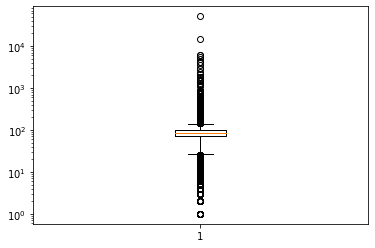

In [221]:
fig, ax = plt.subplots()
ax.boxplot(df_movie_basics.runtime_minutes.dropna())
ax.set_yscale('log');


In [242]:
descriptives = df_movie_basics[df_movie_basics['runtime_minutes'] < 584].runtime_minutes.dropna().describe()
descriptives

count    114356.000000
mean         84.947121
std          29.253185
min           1.000000
25%          70.000000
50%          87.000000
75%          99.000000
max         549.000000
Name: runtime_minutes, dtype: float64

Below we use the boxplot method to identify the whiskers. Thus from below, any movie that runs for less than 26.5 minutes will be treated as a lower limit outlier.

The analysis also shows we should treat any movie above 142.5 minutes as the upper limit outlier. However, I will use 250 minutes as the upper limit outlier. Given that successful movies like [Avatar 2](shorturl.at/hvwNZ) and [Avengers: Endame](shorturl.at/djlF5) clocked over 180 minutes. [Zack Snyder's Justice League](shorturl.at/nzJSU) was over 240 minutes long.

In [243]:
# use iqr from the boxplot to calculate outlier runtimes
iqr = descriptives[6] - descriptives[4]
lower_whisk = descriptives[4] - (1.5*iqr)
upper_whisk = descriptives[6] + (1.5*iqr)
print(lower_whisk, upper_whisk)

26.5 142.5


In [149]:
# Remove outlier runtime
df_movie_basics[(df_movie_basics['runtime_minutes'] >= 26.5) & (df_movie_basics['runtime_minutes'] <= 250)]

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"
5,tt0111414,A Thin Life,A Thin Life,2018,75.0,Comedy
...,...,...,...,...,...,...
146135,tt9916170,The Rehearsal,O Ensaio,2019,51.0,Drama
146136,tt9916186,Illenau - die Geschichte einer ehemaligen Heil...,Illenau - die Geschichte einer ehemaligen Heil...,2017,84.0,Documentary
146137,tt9916190,Safeguard,Safeguard,2019,90.0,"Drama,Thriller"
146139,tt9916538,Kuambil Lagi Hatiku,Kuambil Lagi Hatiku,2019,123.0,Drama


In [153]:
df_movie_basics[df_movie_basics['runtime_minutes'].isna()].sample(20)

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
108777,tt6389350,Rotten: A Small World,Rotten: A Small World,2016,NaN,Thriller
80399,tt4620516,Berlin Charlottenburg - Ein Tag im alten Westen,Berlin Charlottenburg - Ein Tag im alten Westen,2015,NaN,Documentary
75996,tt4339030,Potta Potti,Potta Potti,2011,NaN,"Comedy,Romance"
97383,tt5684468,Retrats,Retrats,2010,NaN,Documentary
105682,tt6180548,Siostra,Siostra,2017,NaN,Drama
17300,tt1781919,A Bear Lands on Earth,A Bear Lands on Earth,2016,NaN,Comedy
55284,tt3240086,Watashi no Hawaii no arukikata,Watashi no Hawaii no arukikata,2014,NaN,"Comedy,Romance"
145471,tt9821246,Unrivaled: Earnhardt vs. Gordon,Unrivaled: Earnhardt vs. Gordon,2019,NaN,"Documentary,Sport"
3760,tt10364272,Alienated,Alienated,2020,NaN,Sci-Fi
125322,tt7633128,Lluvias,Lluvias,2017,NaN,Documentary


In [95]:
df_movie_basics[df_movie_basics['runtime_minutes'] < 90].sort_values('runtime_minutes', ascending=False).head(20)

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
45112,tt2673318,The Repairman,The Repairman,2013,89.0,"Comedy,Drama"
37351,tt2356058,Bunyip the Movie,Bunyip the Movie,2013,89.0,Comedy
117553,tt7011130,I Am You,I Am You,2019,89.0,Drama
117519,tt7008470,Happy Birth Death,Happy Birth Death,2016,89.0,"Horror,Thriller"
14093,tt1706419,La mano de Satán,La mano de Satán,2010,89.0,Comedy
117453,tt7000030,Chronic,Chronic,2017,89.0,Drama
61134,tt3529986,Proud Citizen,Proud Citizen,2014,89.0,"Comedy,Drama"
14119,tt1706679,Et in terra pax,Et in terra pax,2010,89.0,"Crime,Drama"
117334,tt6987760,Snake Outta Compton,Snake Outta Compton,2018,89.0,"Comedy,Horror,Sci-Fi"
117322,tt6987074,Around the World in 80 Anthems,Around the World in 80 Anthems,2017,89.0,Documentary


In [170]:
ratings = """SELECT * 
                      FROM movie_ratings;"""

df_ratings = pd.read_sql(ratings, conn)
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73856 entries, 0 to 73855
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   movie_id       73856 non-null  object 
 1   averagerating  73856 non-null  float64
 2   numvotes       73856 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 1.7+ MB


### Investigating Duplicates in "primary_title" & "original_title"
We need to make some considerations when looking at these duplicates:

1.titles may be duplicated because we have different movies with the same name. For example, in the output below, we have 2 movies with the name "10 Minutes". A quick Google search shows that the one produced in 2013 is different from that in 2015

In [56]:
df_movie_basics[df_movie_basics.primary_title.duplicated(
                keep=False)].sort_values(by='primary_title', key=lambda x: x.str.lower()).head(20)

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
131857,tt8219776,#5,#5,2018,NaN,Documentary
52892,tt3120962,#5,#5,2013,68.0,"Biography,Comedy,Fantasy"
106201,tt6214664,(aguirre),(aguirre),2016,98.0,"Biography,Comedy,Documentary"
103890,tt6085916,(aguirre),(aguirre),2016,97.0,"Biography,Documentary"
100818,tt5891614,1,1,2016,22.0,Documentary
20620,tt1859618,1,1,2019,100.0,Drama
42007,tt2518788,1,1,2013,112.0,"Documentary,History,Sport"
30680,tt2170245,10,10,2012,76.0,Thriller
22983,tt1941430,10,10,2011,NaN,Action
91348,tt5282238,10,10,2015,90.0,Thriller


In [6]:
# check for missing values
df_movie_basics.isna().any()

movie_id           False
primary_title      False
original_title      True
start_year         False
runtime_minutes     True
genres              True
dtype: bool

In [7]:
# check for duplicates
df_movie_basics.duplicated().value_counts()

False    146144
dtype: int64

### Persons Table
This table contains "primary_name" column which will be important especially when we start to look at top performing movies to answer the questions like who are their main actors, or who directed these movies, to see if there is a common pattern of stars and directors that feature in top performing movies. Thus we will look at keeping this column. We will not keep "primary_profession" column since it has multiple values for each person, and we can get pretty much the same information from
categories in the principals table

Below output shows that our columns of interest "person_id" & "primary_name" don't have missing values

In [27]:
# open the persons table

m_basics = """
SELECT *
   FROM persons;
"""
df_persons = pd.read_sql(m_basics, conn)

# we will focus exploration on columns of
#interest i.e "person_id" & "primary_name"
print(df_persons.info())
print('\n')
print([df_persons.isnull().any()])

# preview the first 5 rows
df_persons.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 606648 entries, 0 to 606647
Data columns (total 5 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   person_id           606648 non-null  object 
 1   primary_name        606648 non-null  object 
 2   birth_year          82736 non-null   float64
 3   death_year          6783 non-null    float64
 4   primary_profession  555308 non-null  object 
dtypes: float64(2), object(3)
memory usage: 23.1+ MB
None


[person_id             False
primary_name          False
birth_year             True
death_year             True
primary_profession     True
dtype: bool]


,person_id,primary_name,birth_year,death_year,primary_profession
0,nm0061671,Mary Ellen Bauder,NaN,NaN,"miscellaneous,production_manager,producer"
1,nm0061865,Joseph Bauer,NaN,NaN,"composer,music_department,sound_department"
2,nm0062070,Bruce Baum,NaN,NaN,"miscellaneous,actor,writer"
3,nm0062195,Axel Baumann,NaN,NaN,"camera_department,cinematographer,art_department"
4,nm0062798,Pete Baxter,NaN,NaN,"production_designer,art_department,set_decorator"


### Check for Duplicates
When we check for duplicates below, we realise that primary names have duplicates, but "person_id" don't. This means that we may have some people with the same names, and can therefore only be distinguised by their "person_id"

In [9]:
# check for duplicates
print('primary name')
print(df_persons.primary_name.duplicated().value_counts())
print('\n')
print('person id')
print(df_persons.person_id.duplicated().value_counts())

primary name
False    577203
True      29445
Name: primary_name, dtype: int64


person id
False    606648
Name: person_id, dtype: int64


However, since we lack more context on the data, and how the "person_id" relates to "primary_name" it is also difficult to tell whether the duplicates below belong to the same person, since the database would have been compiled over a long period of time. In that case it would be possible for a person to be added to the database at different time periods with different "person_id" 

When I join this table to the movie basics table, I will make some assumptions to enable me identify "actual" duplicates. e.g. if we have the same primary name appearing more than once in a movie, then those are likely to be duplicates

See below a dataframe of all duplicated primary names

In [28]:
df_persons[df_persons.primary_name.duplicated(keep=False)].sort_values(by='primary_name', key=lambda x: x.str.lower()).head(10)

,person_id,primary_name,birth_year,death_year,primary_profession
279631,nm4062141,A. Venkatesh,NaN,NaN,"director,actor,writer"
156216,nm1701176,A. Venkatesh,NaN,NaN,"cinematographer,camera_department,editor"
129377,nm10275444,A. Venkatesh,NaN,NaN,director
387377,nm8956236,A. Venkatesh,NaN,NaN,producer
436444,nm6758318,A.J. Khan,NaN,NaN,producer
30159,nm0451160,A.J. Khan,1977.0,NaN,"actress,make_up_department,director"
565680,nm7645047,A.K. Azad,NaN,NaN,"music_department,composer"
398340,nm8244210,A.K. Azad,NaN,NaN,actor
262683,nm3942577,Aadhi,NaN,NaN,"actor,music_department,soundtrack"
446609,nm6832961,Aadhi,NaN,NaN,actor


### Principals Table
This table contains a useful column "category", which describes the roles/profession of each person in a film. Joining this to "primary_name" column from persons table will help us do away with the "primary_profession" column, which is messy

The table, by design has duplicated values for all columns, since it shows all cast members that appeared in each movie. As a result, since each person is likely to have participated in more than one movie, and each movie has more than one cast member

However, there is a possibility that we have multiple movie id's belonging to the same movie (due to different versions accounting for language etc), so we will address that when we join this table to movie basics, which contains the original movie ids & titles, thus any invalid duplicates will be visible then


In [13]:
# open the principals table

principals = """
SELECT *
   FROM principals;
"""
df_principals = pd.read_sql(principals, conn)

# check for dataframe row duplicates
print('check for dataframe row duplicates')
print(df_principals.duplicated().value_counts())
print('\n')

# check for col row duplicates
print('check for column row duplicates')
for output in [df_principals[col].duplicated().value_counts() for col in df_principals.columns]:
    print(output)
    print('\n')

# check for missing values
print('check for missing values')
print(df_principals.isnull().any())

# preview the first 5 rows
df_principals.head()

check for dataframe row duplicates
False    1028186
dtype: int64


check for column row duplicates
True     884732
False    143454
Name: movie_id, dtype: int64


True     1028176
False         10
Name: ordering, dtype: int64


False    604546
True     423640
Name: person_id, dtype: int64


True     1028174
False         12
Name: category, dtype: int64


True     1025220
False       2966
Name: job, dtype: int64


True     853423
False    174763
Name: characters, dtype: int64


check for missing values
movie_id      False
ordering      False
person_id     False
category      False
job            True
characters     True
dtype: bool


,movie_id,ordering,person_id,category,job,characters
0,tt0111414,1,nm0246005,actor,None,"[""The Man""]"
1,tt0111414,2,nm0398271,director,None,None
2,tt0111414,3,nm3739909,producer,producer,None
3,tt0323808,10,nm0059247,editor,None,None
4,tt0323808,1,nm3579312,actress,None,"[""Beth Boothby""]"


The output below shows that the actor nm9861411 appeared 4 different movies as "The Noob". This reinforces the above point of the same movie having different versions - highly unlikely that the same actor would be cast as "The Noob" in 4 different unrelated movies

In [31]:
df_principals[df_principals['person_id'] == 'nm9861411']

,movie_id,ordering,person_id,category,job,characters
878454,tt8574528,1,nm9861411,actor,None,"[""The Noob""]"
1013101,tt8469414,1,nm9861411,actor,None,"[""The Noob""]"
1013231,tt8525414,1,nm9861411,actor,None,"[""The Noob""]"
1017079,tt8479986,1,nm9861411,actor,None,"[""The Noob""]"


Each cast member is likely to have appeared in more than one movie, as highlighted by the example below

In [30]:
df_principals[df_principals['person_id'] == 'nm1930572'].head(10)

,movie_id,ordering,person_id,category,job,characters
7271,tt1801509,3,nm1930572,composer,None,None
16466,tt1805164,9,nm1930572,composer,None,None
20175,tt1607598,8,nm1930572,composer,None,None
24791,tt1620748,7,nm1930572,composer,None,None
29594,tt1596776,7,nm1930572,composer,None,None
30782,tt1930355,7,nm1930572,composer,None,None
32106,tt2178300,6,nm1930572,composer,None,None
33904,tt1603386,7,nm1930572,composer,composer,None
36325,tt2099628,6,nm1930572,composer,None,None
39502,tt1723736,6,nm1930572,composer,None,None


From the 2 outputs below, we see that that the ordering column ranks all cast members in a movie in some particular order. The ranks are not consistent across movies as shown by the 2 examples below, but the actors are ranked higher than the other cast members

In [15]:
df_principals[df_principals['movie_id'] == 'tt8525414']

,movie_id,ordering,person_id,category,job,characters
1013231,tt8525414,1,nm9861411,actor,None,"[""The Noob""]"
1013232,tt8525414,2,nm1930572,composer,None,None
1013233,tt8525414,3,nm3635913,composer,None,None


In [33]:
df_principals[df_principals['movie_id'] == 'tt0837562']

,movie_id,ordering,person_id,category,job,characters
218624,tt0837562,10,nm1156984,writer,story by,None
218625,tt0837562,1,nm0001191,actor,None,"[""Dracula""]"
218626,tt0837562,2,nm0416673,actor,None,"[""Frankenstein""]"
218627,tt0837562,3,nm1676221,actor,None,"[""Jonathan""]"
218628,tt0837562,4,nm1411125,actress,None,"[""Mavis""]"
218629,tt0837562,5,nm0850733,director,None,None
218630,tt0837562,6,nm0063165,writer,screenplay by,None
218631,tt0837562,7,nm0806912,writer,screenplay by,None
218632,tt0837562,8,nm0244110,writer,story by,None
218633,tt0837562,9,nm1087952,writer,story by,None


In [18]:
# open the movie_akas table - contains different versions of the same movie in different languages
# no valuable data relevant to the analysis, so excluded 

m_akas = """
SELECT *
   FROM movie_akas;
"""
df_m_akas = pd.read_sql(m_akas, conn)

# check for dataframe row duplicates
print('check for dataframe row duplicates')
print(df_m_akas.duplicated().value_counts())
print('\n')

# check for col row duplicates
print('check for column row duplicates')
for output in [df_m_akas[col].duplicated().value_counts() for col in df_m_akas.columns]:
    print(output)
    print('\n')

# check for missing values
print('check for missing values')
print(df_m_akas.isnull().any())

# preview the first 5 rows
df_m_akas.head()

check for dataframe row duplicates
False    331703
dtype: int64


check for column row duplicates
True     209401
False    122302
Name: movie_id, dtype: int64


True     331642
False        61
Name: ordering, dtype: int64


False    252781
True      78922
Name: title, dtype: int64


True     331489
False       214
Name: region, dtype: int64


True     331626
False        77
Name: language, dtype: int64


True     331692
False        11
Name: types, dtype: int64


True     331625
False        78
Name: attributes, dtype: int64


True     331700
False         3
Name: is_original_title, dtype: int64


check for missing values
movie_id             False
ordering             False
title                False
region                True
language              True
types                 True
attributes            True
is_original_title     True
dtype: bool


,movie_id,ordering,title,region,language,types,attributes,is_original_title
0,tt0369610,10,Джурасик свят,BG,bg,None,None,0.0
1,tt0369610,11,Jurashikku warudo,JP,None,imdbDisplay,None,0.0
2,tt0369610,12,Jurassic World: O Mundo dos Dinossauros,BR,None,imdbDisplay,None,0.0
3,tt0369610,13,O Mundo dos Dinossauros,BR,None,None,short title,0.0
4,tt0369610,14,Jurassic World,FR,None,imdbDisplay,None,0.0


In [76]:
df_m_akas[df_m_akas['movie_id'] == 'tt10042446']

,movie_id,ordering,title,region,language,types,attributes,is_original_title


In [19]:
# open the known_for table

known_for = """
SELECT *
   FROM known_for;
"""
df_known_for = pd.read_sql(known_for, conn)

# check for dataframe row duplicates
print('check for dataframe row duplicates')
print(df_known_for.duplicated().value_counts())
print('\n')

# check for col row duplicates
print('check for column row duplicates')
for output in [df_known_for[col].duplicated().value_counts() for col in df_known_for.columns]:
    print(output)
    print('\n')

# check for missing values
print('check for missing values')
print(df_known_for.isnull().any())

# preview the first 5 rows
df_known_for.head()

check for dataframe row duplicates
False    1638260
dtype: int64


check for column row duplicates
True     1061816
False     576444
Name: person_id, dtype: int64


True     1123479
False     514781
Name: movie_id, dtype: int64


check for missing values
person_id    False
movie_id     False
dtype: bool


,person_id,movie_id
0,nm0061671,tt0837562
1,nm0061671,tt2398241
2,nm0061671,tt0844471
3,nm0061671,tt0118553
4,nm0061865,tt0896534


In [20]:
tab = """
SELECT p.category
   FROM principals p
   JOIN known_for k
   on p.person_id = k.person_id;
"""
df_tab = pd.read_sql(tab, conn)
df_tab.head()

,category
0,actor
1,actor
2,actor
3,actor
4,director


In [21]:
df_tab.category.value_counts()

actor                  805595
director               476164
actress                475742
producer               380565
cinematographer        274694
composer               242025
writer                 229409
editor                 191929
self                   160471
production_designer     31402
archive_footage         10242
archive_sound              47
Name: category, dtype: int64

In [22]:
tab1 = """
SELECT p.person_id, p.category, p.characters
   FROM principals p
   JOIN directors d
   on p.person_id = d.person_id;
"""
df_tab1 = pd.read_sql(tab1, conn)
print(df_tab1.shape)
print('\n')
print(df_tab1.value_counts())
df_tab1.head()

(1008510, 3)


person_id  category  characters              
nm3266654  actor     ["Actor","Singer"]          1426
nm0442207  self      ["Himself"]                  583
nm6935209  self      ["Himself"]                  476
nm3266654  self      ["Himself"]                  434
nm5954636  actor     ["Sergey"]                   405
                                                 ... 
nm3705299  actor     ["Cook Zombie"]                1
nm3705364  actor     ["Jason"]                      1
nm3705911  actor     ["Comandante borbonico"]       1
nm3709910  actor     ["Mungo"]                      1
nm9992905  self      ["Himself"]                    1
Length: 28782, dtype: int64


,person_id,category,characters
0,nm0398271,director,None
1,nm0398271,director,None
2,nm0574615,actor,"[""Sir Lachlan Morrison""]"
3,nm0362736,director,None
4,nm0330974,actress,"[""Diana""]"


In [23]:
df_tab1[df_tab1['person_id'] == 'nm9861411']

,person_id,category,characters
866424,nm9861411,actor,"[""The Noob""]"
866425,nm9861411,actor,"[""The Noob""]"
866426,nm9861411,actor,"[""The Noob""]"
866427,nm9861411,actor,"[""The Noob""]"
994197,nm9861411,actor,"[""The Noob""]"
994198,nm9861411,actor,"[""The Noob""]"
994199,nm9861411,actor,"[""The Noob""]"
994200,nm9861411,actor,"[""The Noob""]"
994307,nm9861411,actor,"[""The Noob""]"
994308,nm9861411,actor,"[""The Noob""]"
